In [3]:
%matplotlib widget

from collections import deque
from typing import Any
from typing import OrderedDict

import matplotlib.pyplot as plt
import networkx as nx
from solution import DIRECTION_VECTORS
from solution import Contestant
from solution import ContestantState
from solution import Coord
from solution import Direction
from solution import Entity
from solution import EntityKind
from solution import GameState
from solution import Node


# For testing with Jupyter
def read_game_state_from_file(path: str) -> tuple[int, int, GameState]:
    # Read entities and cache by uid without refrence to root or parent
    with open(path, "r") as buffer:
        width, height = [int(i) for i in buffer.readline().strip().split()]

        tmp_entities: dict[
            int, tuple[Entity, int | None, int | None]
        ] = {}  # uid: (entity, parent_uid, root_uid)
        for idx in range(int(buffer.readline().strip())):
            (
                _x,
                _y,
                _kind,
                _owner,
                _uid,
                _dir,
                _parent_uid,
                _root_uid,
            ) = buffer.readline().strip().split()

            _tmp_uid = int(_uid) if int(_uid) else (-idx)
            tmp_entities[_tmp_uid] = (
                Entity(
                    uid=_tmp_uid,
                    x=int(_x),
                    y=int(_y),
                    kind=EntityKind(_kind),
                    owner=None if _owner == "-1" else Contestant(_owner),
                    direction=Direction(_dir),
                    root=None,
                    parent=None,
                ),
                None if int(_parent_uid) == -1 else int(_parent_uid),
                None if int(_root_uid) == -1 else int(_root_uid),
            )

        # Process entities
        entities: dict[Coord, Entity] = {}
        roots: dict[Contestant, Entity] = {}

        for entity, parent_uid, root_uid in tmp_entities.values():
            if parent_uid:
                entity = entity.update_parent(tmp_entities[parent_uid][0])
            if root_uid:
                entity = entity.update_root(tmp_entities[root_uid][0])

            entities[entity.coord] = entity
            if entity.kind == EntityKind.ROOT and entity.owner:
                roots[entity.owner] = entity

        my_a, my_b, my_c, my_d = [int(i) for i in buffer.readline().strip().split()]
        player_state = ContestantState(
            root=roots[Contestant.PLAYER],
            protein_a=my_a,
            protein_b=my_b,
            protein_c=my_c,
            protein_d=my_d,
        )

        opp_a, opp_b, opp_c, opp_d = [int(i) for i in buffer.readline().strip().split()]
        opponent_state = ContestantState(
            root=roots[Contestant.OPPONENT],
            protein_a=opp_a,
            protein_b=opp_b,
            protein_c=opp_c,
            protein_d=opp_d,
        )

        required_actions_count = int(buffer.readline().strip())

        return (
            width,
            height,
            GameState(
                player=player_state,
                opponent=opponent_state,
                entities=entities,
                actions=required_actions_count,
            ),
        )


def debug(*args: Any, **kwargs: Any) -> None:
    print(*args, **kwargs)


width, height, game_state = read_game_state_from_file("./inputs/wood_3.txt")
entities, player, opponent = game_state.entities, game_state.player, game_state.opponent


In [11]:
""" Step 1: build graph from the player root & capture features & possible strategies"""

nodes: dict[Coord, Node] = {}
features: dict[Coord, Node] = {}
unvisited_coords: deque[Coord] = deque([player.root.coord])
visited_coords: set[Coord] = set()

# Prepopulate the graph with the player entire organism at this point
pre_player_organs: list[Entity] = sorted(
    [
        organ
        for organ in entities.values()
        if organ.kind in EntityKind.ORGANISMS and organ.owner == Contestant.PLAYER
    ],
    key=lambda x: x.uid,
)

for organ in pre_player_organs:
    if organ.coord not in nodes:
        nodes[organ.coord] = Node(x=organ.x, y=organ.y, entity=organ)

for node in nodes.values():
    if not node.parent and node.entity and node.entity.parent:
        parent_node = nodes[node.entity.parent.coord]
        parent_node.children.add(node)
        node.parent = parent_node

for coord, node in nodes.items():
    debug(coord, node.parent.coord if node.parent else None, node)

# Walk the graph and build all other nodes
while unvisited_coords:
    coord = unvisited_coords.popleft()
    if coord in visited_coords:
        continue

    x, y = coord
    node = nodes[coord]

    skip_children_and_features = any(
        [
            node.entity and node.entity.owner == Contestant.OPPONENT,
            node.entity and node.entity.kind in EntityKind.PROTEINS,
        ]
    )

    for direction, (i, j) in DIRECTION_VECTORS.items():
        c_x, c_y = coord[0] + i, coord[1] + j
        c_coord = (c_x, c_y)
        c_entity = entities.get(c_coord)

        if any(
            (
                c_x < 0 or c_x >= width,
                c_y < 0 or c_y >= height,
                c_entity and c_entity.kind == EntityKind.WALL,
            )
        ):
            continue

        if c_coord not in nodes and not skip_children_and_features:
            c_node = Node(x=c_x, y=c_y, entity=c_entity, parent=node)
            nodes[c_coord] = c_node
            unvisited_coords.appendleft(c_coord)

            if True and any(
                [
                    # The node is empty
                    not c_entity,
                    # ... or the node is a player organism
                    c_entity
                    and c_entity.kind in EntityKind.ORGANISMS
                    and c_entity
                    and c_entity.owner
                    and c_entity.owner == Contestant.PLAYER,
                ]
            ):
                node.children.add(c_node)

            if any(
                [
                    # The feature is a protein
                    c_entity and c_entity.kind in EntityKind.PROTEINS,
                    # ... or the feature is an opponent organism
                    c_entity
                    and c_entity.kind in EntityKind.ORGANISMS
                    and c_entity.owner
                    and c_entity.owner == Contestant.OPPONENT,
                ]
            ):
                node.features[direction] = c_node
                features[c_coord] = c_node

    visited_coords.add(coord)

debug("Features:")
features = OrderedDict(
    sorted(
        features.items(),
        key=lambda x: (x[1].entity.uid if x[1].entity else 100000000),
    )
)
for coord, node in features.items():
    debug(f"{coord}: {node} ({node.entity.kind if node.entity else ''})")
debug()


(1, 2) <(1, 2) - Entity(uid=1, x=1, y=2, kind=<EntityKind.ROOT: 'ROOT'>, owner=<Contestant.PLAYER: '1'>, direction=<Direction.NORTH: 'N'>, parent=None, root=Entity(uid=1, x=1, y=2, kind=<EntityKind.ROOT: 'ROOT'>, owner=<Contestant.PLAYER: '1'>, direction=<Direction.NORTH: 'N'>, parent=None, root=None))>
(1, 3) <(1, 3) - Entity(uid=100, x=1, y=3, kind=<EntityKind.BASIC: 'BASIC'>, owner=<Contestant.PLAYER: '1'>, direction=<Direction.NONE: 'X'>, parent=Entity(uid=1, x=1, y=2, kind=<EntityKind.ROOT: 'ROOT'>, owner=<Contestant.PLAYER: '1'>, direction=<Direction.NORTH: 'N'>, parent=None, root=None), root=Entity(uid=1, x=1, y=2, kind=<EntityKind.ROOT: 'ROOT'>, owner=<Contestant.PLAYER: '1'>, direction=<Direction.NORTH: 'N'>, parent=None, root=None))>
(1, 4) <(1, 4) - Entity(uid=101, x=1, y=4, kind=<EntityKind.BASIC: 'BASIC'>, owner=<Contestant.PLAYER: '1'>, direction=<Direction.NONE: 'X'>, parent=Entity(uid=100, x=1, y=3, kind=<EntityKind.BASIC: 'BASIC'>, owner=<Contestant.PLAYER: '1'>, direc

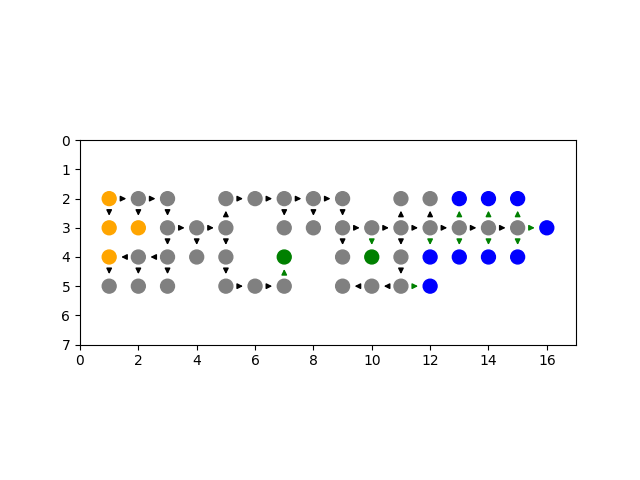

In [8]:
G = nx.DiGraph()

for node in nodes.values():
    G.add_node(node)
    for child in node.children:
        G.add_edge(node, child, kind="grow")
    for feature in node.features.values():
        G.add_edge(node, feature, kind="feature")

node_colormap = []
for node in G.nodes:
    if node.entity and node.entity.owner == Contestant.PLAYER:
        node_colormap.append("orange")
    elif node.entity and node.entity.owner == Contestant.OPPONENT:
        node_colormap.append("blue")
    elif node.entity and node.entity.kind in EntityKind.PROTEINS:
        node_colormap.append("green")
    elif node.tentative:
        node_colormap.append("lightgray")
    else:
        node_colormap.append("gray")

edge_colormap = []
for edge in G.edges:
    if G.edges[edge]["kind"] == "grow":
        edge_colormap.append("black")
    else:
        edge_colormap.append("green")

pos = {node: node.coord for node in nodes.values()}


# add axis
fig, ax = plt.subplots()
nx.draw_networkx_nodes(
    G,
    pos=pos,
    node_size=100,
    ax=ax,
    node_color=node_colormap,  # type: ignore
)
nx.draw_networkx_edges(
    G,
    pos,
    ax=ax,
    width=1,
    arrowstyle="-|>",
    arrowsize=8,
    edge_color=edge_colormap,  # type: ignore
)
plt.axis("on")
ax.set_xlim(0, width - 1)
ax.set_ylim(height - 1, 0)
ax.set_aspect("equal")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [9]:
""" Step 2: define best feature nodes which maximize fitness of the game

For future self: this means, go through all enemy organs and proteins, and find the
    best places/orientations to put these organs and proteins, such that the player can 
    minimize cost and maximize fitness.
"""

visited_feature_coords: set[Coord] = set()
feature_edges: set[tuple[Node, Node]] = set()
for coord, feature in features.items():
    if not feature.parent:
        debug("Feature without parent", coord, feature)
        continue

    if feature.parent.coord in visited_feature_coords:
        continue
    visited_feature_coords.add(feature.parent.coord)

    node, parent = feature, feature.parent
    while parent:
        feature_edges.add((parent, node))
        node, parent = parent, parent.parent

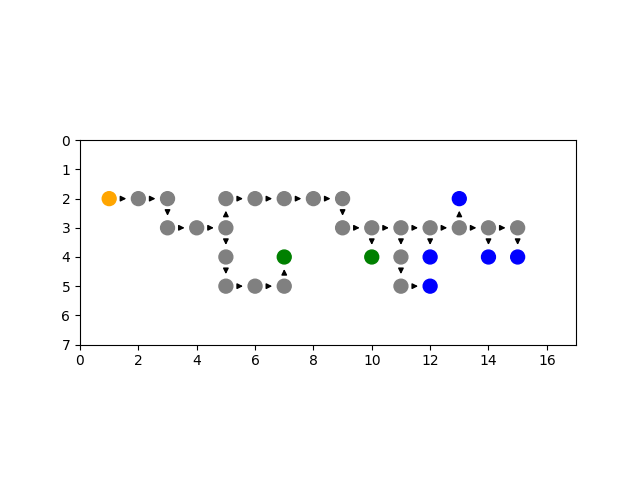

In [10]:
G_FEATURE = nx.DiGraph(feature_edges)

node_colormap = []
for node in G_FEATURE.nodes:
    if node.entity and node.entity.owner == Contestant.PLAYER:
        node_colormap.append("orange")
    elif node.entity and node.entity.owner == Contestant.OPPONENT:
        node_colormap.append("blue")
    elif node.entity and node.entity.kind in EntityKind.PROTEINS:
        node_colormap.append("green")
    elif node.tentative:
        node_colormap.append("lightgray")
    else:
        node_colormap.append("gray")

pos = {node: node.coord for node in nodes.values()}


# add axis
fig, ax = plt.subplots()
nx.draw_networkx_nodes(
    G_FEATURE,
    pos=pos,
    node_size=100,
    ax=ax,
    node_color=node_colormap,  # type: ignore
)
nx.draw_networkx_edges(
    G_FEATURE,
    pos,
    ax=ax,
    width=1,
    arrowstyle="-|>",
    arrowsize=8,
    edge_color="black",  # type: ignore
)
plt.axis("on")
ax.set_xlim(0, width - 1)
ax.set_ylim(height - 1, 0)
ax.set_aspect("equal")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()
